# OCR Preprocessing Pipeline for Renaissance Documents

This notebook randomly samples pages from a set of PDF documents, converts them to images, and applies a standard OCR preprocessing pipeline:
- Grayscale conversion
- Noise removal (median filter)
- Binarization (Otsu’s threshold)
- Deskewing

You'll end up with clean, black-and-white PNG files ready for OCR.



### 1. Install Dependencies

Run the following cell to install necessary packages (requires Poppler installed on your system):


In [1]:

%pip install pdf2image opencv-python numpy gdown



Note: you may need to restart the kernel to use updated packages.



### 2. Imports and Configuration

Adjust the paths below to point to your PDF directory and desired output folder.

In [8]:
import os
import random
from pdf2image import convert_from_path
import cv2
import numpy as np

# %%
from pathlib import Path
from PIL import Image

# Turn off the check entirely:
Image.MAX_IMAGE_PIXELS = None

# Directory containing your PDF files
pdf_dir = '/data/pdfs'
# Directory where preprocessed images will be saved
output_dir = '/data/processed_data'

POPPLER_PATH = 'C:/Users/katej/OneDrive/Documents/Downloads/Release-24.08.0-0/poppler-24.08.0/Library/bin/'


os.makedirs(output_dir, exist_ok=True)

# Set DPI for conversion
DPI = 300

# Number of documents and pages to sample
NUM_DOCUMENTS = 6
PAGES_PER_DOC = 5

In [3]:
Path(pdf_dir).mkdir(parents=True, exist_ok=True)

FOLDER_ID = '1dv3wPi5-FoVC5BFtf4HFNJyqxUb500wN'

gdown_command = f"gdown --folder https://drive.google.com/drive/folders/{FOLDER_ID} -O {pdf_dir}"
print('Running:', gdown_command)
!{gdown_command}

print(f"Downloaded PDFs into {pdf_dir}")


Running: gdown --folder https://drive.google.com/drive/folders/1dv3wPi5-FoVC5BFtf4HFNJyqxUb500wN -O /data/pdfs
Processing file 1E7bnev2iGtg6AyGc1s8VNhLUUntdv3er Ayala, Lorenzo de. Valladolid 1603.pdf
Processing file 1L-hYw-dH52EQm5Di2ZhgPWEuscL3cF7f Burgos, Juan de. Valladolid 1500.pdf
Processing file 17uxQuvlHBHSAWtb0UCKmGKIhg0WZPXfm Cansoles, Fernando. Mallorca 1541.pdf
Processing file 1oJ-3nSMZ0nsBV5bDFlil4hoOGQy5YTFh Cerda - Estados mujeres OG color.pdf
Processing file 1YkN5ZWdr6veG1JPNRrvKfK0ijFyNlkST Guevara - Reloj de Principes OG.pdf
Processing file 1KrNnuKv-C6iqt75AkIq3F7HOfvS-Ufzx PORCONES.323.48 - 1626.pdf
Downloaded PDFs into /data/pdfs


Retrieving folder contents
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1E7bnev2iGtg6AyGc1s8VNhLUUntdv3er
To: c:\data\pdfs\Ayala, Lorenzo de. Valladolid 1603.pdf

  0%|          | 0.00/6.42M [00:00<?, ?B/s]
  8%|▊         | 524k/6.42M [00:00<00:01, 4.59MB/s]
 49%|████▉     | 3.15M/6.42M [00:00<00:00, 16.6MB/s]
100%|██████████| 6.42M/6.42M [00:00<00:00, 20.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L-hYw-dH52EQm5Di2ZhgPWEuscL3cF7f
To: c:\data\pdfs\Burgos, Juan de. Valladolid 1500.pdf

  0%|          | 0.00/52.7M [00:00<?, ?B/s]
  1%|          | 524k/52.7M [00:00<00:23, 2.26MB/s]
  4%|▍         | 2.10M/52.7M [00:00<00:17, 2.93MB/s]
  6%|▌         | 3.15M/52.7M [00:01<00:17, 2.89MB/s]
  9%|▉         | 4.72M/52.7M [00:01<00:10, 4.67MB/s]
 12%|█▏        | 6.29M/52.7M [00:01<00:07, 6.54MB/s]
 15%|█▍        | 7.86M/52.7M [00:01<00:05, 8.33MB/s]
 20%|█▉        | 10.5


### 3. Sampling PDFs and Pages

This cell selects `NUM_DOCUMENTS` random PDFs and then samples up to `PAGES_PER_DOC` pages from each.

In [4]:
import os
# List all PDF files in the directory
pdf_files = [f for f in os.listdir(pdf_dir) if f.lower().endswith('.pdf')]
# Sample documents
sampled_docs = random.sample(pdf_files, min(NUM_DOCUMENTS, len(pdf_files)))

print(f"Sampling {len(sampled_docs)} documents:", sampled_docs)

# List all PDF files in the directory
pdf_files = [f for f in os.listdir(pdf_dir) if f.lower().endswith('.pdf')]
# Sample documents
sampled_docs = random.sample(pdf_files, min(NUM_DOCUMENTS, len(pdf_files)))

print(f"Sampling {len(sampled_docs)} documents:", sampled_docs)




Sampling 6 documents: ['Cerda - Estados mujeres OG color.pdf', 'Ayala, Lorenzo de. Valladolid 1603.pdf', 'Burgos, Juan de. Valladolid 1500.pdf', 'Guevara - Reloj de Principes OG.pdf', 'PORCONES.323.48 - 1626.pdf', 'Cansoles, Fernando. Mallorca 1541.pdf']
Sampling 6 documents: ['Burgos, Juan de. Valladolid 1500.pdf', 'Ayala, Lorenzo de. Valladolid 1603.pdf', 'PORCONES.323.48 - 1626.pdf', 'Guevara - Reloj de Principes OG.pdf', 'Cerda - Estados mujeres OG color.pdf', 'Cansoles, Fernando. Mallorca 1541.pdf']



### 4. Preprocessing Pipeline Function

Defines a function to process a single image: grayscale, denoise, binarize, deskew.


In [5]:

def preprocess_image(img_cv):
    # 1. Grayscale
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    # 2. Noise removal
    denoised = cv2.medianBlur(gray, 3)
    # 3. Binarization
    _, bw = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # 4. Deskew
    coords = np.column_stack(np.where(bw > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = bw.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed = cv2.warpAffine(bw, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return deskewed

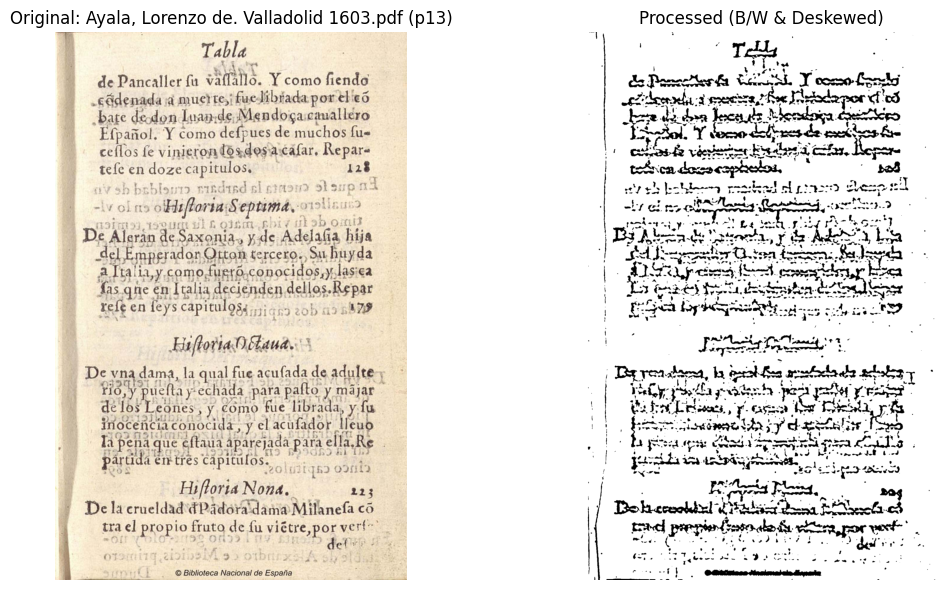

In [ ]:
# %% [markdown]
## Preview Before & After Processing

# %% 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import pdfinfo_from_path, convert_from_path
from PIL import Image

# Disable PIL’s DecompressionBomb protection
Image.MAX_IMAGE_PIXELS = None

# Adjust these paths to your setup
pdf_dir      = r'c:\data\pdfs'
poppler_path = r'C:\Users\katej\OneDrive\Documents\Downloads\Release-24.08.0-0\poppler-24.08.0\Library\bin'
dpi          = 200

# 1. Pick the first PDF and its middle page
files = [f for f in os.listdir(pdf_dir) if f.lower().endswith('.pdf')]
doc       = files[0]
pdf_path  = os.path.join(pdf_dir, doc)
info      = pdfinfo_from_path(pdf_path, poppler_path=poppler_path)
page_num  = info['Pages'] // 2 + 1   # 1-indexed

# 2. Render that single page
pil_page = convert_from_path(
    pdf_path,
    dpi=dpi,
    poppler_path=poppler_path,
    first_page=page_num,
    last_page=page_num,
    fmt='png',
    use_pdftocairo=True,
    thread_count=1
)[0]

import cv2
import numpy as np

def remove_faint_overlay(gray):
    """
    Removes light (faint) overlay text from a grayscale image by:
      1) Top-hat to highlight light regions
      2) Threshold to mask them
      3) Inpaint to erase them
    """
    # 1) Top-hat with a fairly large kernel (tune size to your font height)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 25))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

    # 2) Threshold the top-hat to isolate faint strokes
    #    Lower the threshold if your overlay is very subtle
    _, mask = cv2.threshold(tophat, 50, 255, cv2.THRESH_BINARY)

    # 3) Inpaint the original gray image across that mask
    #    INPAINT_TELEA or INPAINT_NS both work; radius=3–5 is a good starting point
    clean = cv2.inpaint(gray, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)
    return clean
# Example integration:
def preprocess_image(img_bgr):
    # Convert to gray
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Remove faint overlay
    gray_nofaint = remove_faint_overlay(gray)

    # Continue with your denoise & binarization chain, but start from gray_nofaint:
    nlm = cv2.fastNlMeansDenoising(gray_nofaint, h=10, templateWindowSize=7, searchWindowSize=21)
    adapt = cv2.adaptiveThreshold(
        nlm, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, blockSize=35, C=10
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    cleaned = cv2.morphologyEx(adapt, cv2.MORPH_OPEN, kernel)

    # Deskew on `cleaned` as before...
    coords = np.column_stack(np.where(cleaned == 0))
    angle  = cv2.minAreaRect(coords)[-1]
    if angle < -45: angle += 90
    M = cv2.getRotationMatrix2D((cleaned.shape[1]//2, cleaned.shape[0]//2), -angle, 1.0)
    deskewed = cv2.warpAffine(
        cleaned, M, (cleaned.shape[1], cleaned.shape[0]),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )

    return deskewed


# 3. Convert to OpenCV format (BGR)
orig_bgr = cv2.cvtColor(np.array(pil_page), cv2.COLOR_RGB2BGR)

# 4. Preprocessing function
def preprocess_image(img_bgr):
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 2. Non-Local Means denoising
    nlm = cv2.fastNlMeansDenoising(
        gray,
        None,
        h=10,               # strength of the filter
        templateWindowSize=7,
        searchWindowSize=21
    )

    # 3. Adaptive Gaussian thresholding
    adapt = cv2.adaptiveThreshold(
        nlm,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        blockSize=35,       # size of neighborhood
        C=10                # constant subtracted from mean
    )

    # 4. Morphological opening to remove small speckles
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned = cv2.morphologyEx(adapt, cv2.MORPH_OPEN, kernel)

    # 5. (Your existing deskew logic here, using `cleaned` instead of `bw`)
    coords = np.column_stack(np.where(cleaned == 0))
    angle  = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle += 90
    M = cv2.getRotationMatrix2D((cleaned.shape[1]//2, cleaned.shape[0]//2), -angle, 1.0)
    deskewed = cv2.warpAffine(
        cleaned, M, (cleaned.shape[1], cleaned.shape[0]),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )

    return deskewed



processed = preprocess_image(orig_bgr)

# 5. Display side by side
plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB))
plt.title(f"Original: {doc} (p{page_num})")
plt.axis('off')

# Processed
plt.subplot(1, 2, 2)
plt.imshow(processed, cmap='gray')
plt.title("Processed (B/W & Deskewed)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [29]:
import cv2
import numpy as np

def preprocess_image(img_bgr):
    # 1️⃣ Grayscale + CLAHE
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # 2️⃣ Global Otsu (INV so text=255)
    _, bw = cv2.threshold(
        gray, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    # 3️⃣ Close to link strokes (5×5)
    kern_close = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kern_close, iterations=1)

    # 4️⃣ Keep only blobs in [min_area, max_area]
    num_lbl, labels, stats, _ = cv2.connectedComponentsWithStats(bw, 8)
    filtered = np.zeros_like(bw)
    MIN_A, MAX_A = 20, 5000  # tweak these to your text size
    for i in range(1, num_lbl):
        a = stats[i, cv2.CC_STAT_AREA]
        if MIN_A <= a <= MAX_A:
            filtered[labels == i] = 255

    # 5️⃣ Open to remove tiny specks, then dilate to thicken
    kern_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    filtered = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kern_open, iterations=1)
    kern_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    filtered = cv2.dilate(filtered, kern_dilate, iterations=1)

    # 6️⃣ Invert back so text=0, bg=255
    clean = cv2.bitwise_not(filtered)

    # 7️⃣ Deskew on the mask before invert (filtered)
    coords = np.column_stack(np.where(filtered > 0))
    angle  = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle += 90
    h, w = clean.shape
    M = cv2.getRotationMatrix2D((w//2, h//2), -angle, 1.0)
    deskewed = cv2.warpAffine(clean, M, (w, h),
                              flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return deskewed



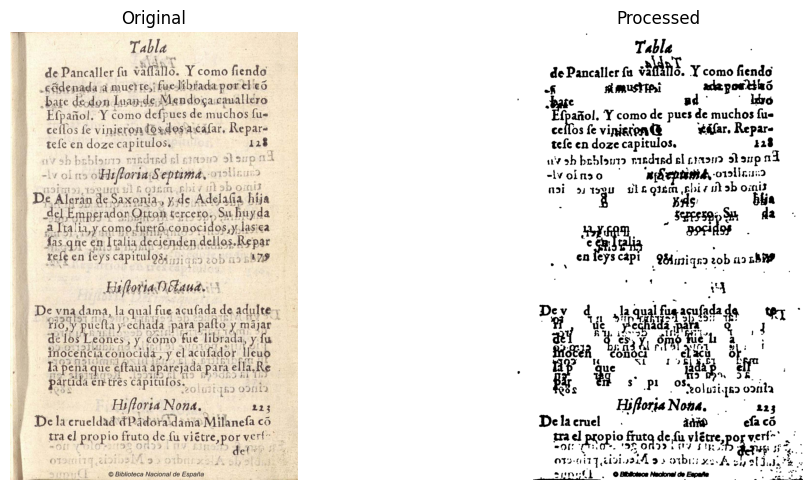

In [30]:
# %% [markdown]
## Preview Before & After with Faint-Text Removal

# %% 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import pdfinfo_from_path, convert_from_path
from PIL import Image

# disable PIL bomb check
Image.MAX_IMAGE_PIXELS = None

# adjust these
pdf_dir      = r'c:\data\pdfs'
poppler_path = r'C:\Users\katej\OneDrive\Documents\Downloads\Release-24.08.0-0\poppler-24.08.0\Library\bin'
dpi          = 200

# pick one PDF & page
files     = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')]
doc       = files[0]
pdf_path  = os.path.join(pdf_dir, doc)
info      = pdfinfo_from_path(pdf_path, poppler_path=poppler_path)
page_num  = info['Pages']//2 + 1

# render page
orig_pil = convert_from_path(
    pdf_path, dpi=dpi, poppler_path=poppler_path,
    first_page=page_num, last_page=page_num,
    fmt='png', use_pdftocairo=True, thread_count=1
)[0]
orig_bgr = cv2.cvtColor(np.array(orig_pil), cv2.COLOR_RGB2BGR)

# process
processed = preprocess_image(orig_bgr)

# show side by side
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(processed, cmap='gray')
plt.title('Processed')
plt.axis('off')

plt.tight_layout()
plt.show()


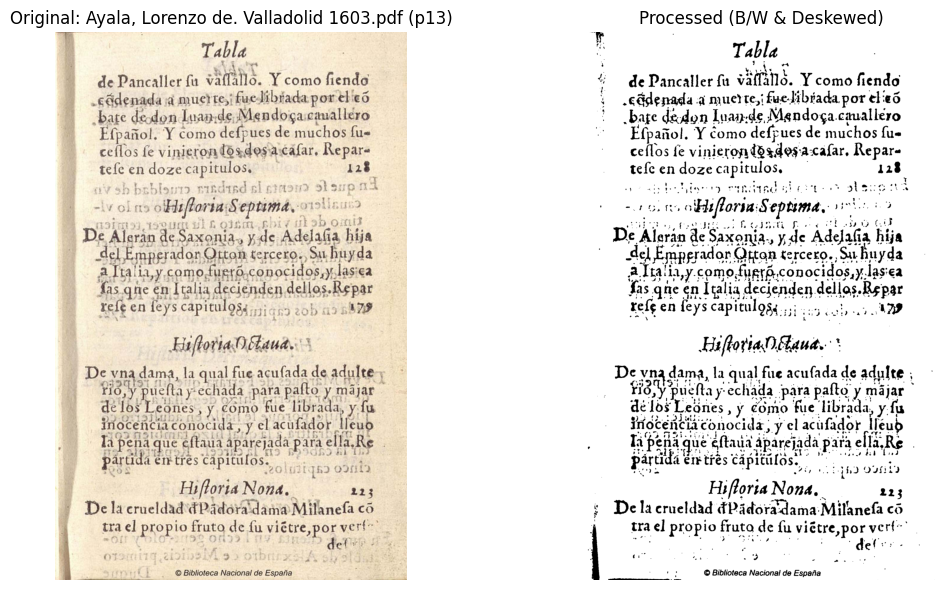

In [4]:
# %% [markdown]
## Preview Before & After Processing

# %% 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import pdfinfo_from_path, convert_from_path
from PIL import Image

# Disable PIL’s DecompressionBomb protection
Image.MAX_IMAGE_PIXELS = None

# Adjust these paths to your setup
pdf_dir      = r'c:\data\pdfs'
poppler_path = r'C:\Users\katej\OneDrive\Documents\Downloads\Release-24.08.0-0\poppler-24.08.0\Library\bin'
dpi          = 200

# 1. Pick the first PDF and its middle page
files = [f for f in os.listdir(pdf_dir) if f.lower().endswith('.pdf')]
doc       = files[0]
pdf_path  = os.path.join(pdf_dir, doc)
info      = pdfinfo_from_path(pdf_path, poppler_path=poppler_path)
page_num  = info['Pages'] // 2 + 1   # 1-indexed

# 2. Render that single page
pil_page = convert_from_path(
    pdf_path,
    dpi=dpi,
    poppler_path=poppler_path,
    first_page=page_num,
    last_page=page_num,
    fmt='png',
    use_pdftocairo=True,
    thread_count=1
)[0]

# 3. Convert to OpenCV format (BGR)
orig_bgr = cv2.cvtColor(np.array(pil_page), cv2.COLOR_RGB2BGR)

# 4. Preprocessing function
def preprocess_image(img_bgr):
    # 1. Grayscale & 2. Denoise
    gray     = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
 

    denoise  = cv2.medianBlur(gray, 3)
    # 3. Binarize (text → 0, background → 255)
    _, bw    = cv2.threshold(denoise, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4. Deskew: compute angle from TEXT pixels (bw==0), not background
    coords = np.column_stack(np.where(bw == 0))
    rect   = cv2.minAreaRect(coords)
    angle  = rect[-1]
    # cv2 gives angles in [−90, 0); adjust so small negative → small positive
    if angle < -45:
        angle = angle + 90

    # Now rotate by –angle to deskew
    (h, w) = bw.shape
    center = (w//2, h//2)
    M      = cv2.getRotationMatrix2D(center, -angle, 1.0)
    deskew = cv2.warpAffine(
        bw, M, (w, h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REPLICATE
    )

    return deskew


processed = preprocess_image(orig_bgr)

# 5. Display side by side
plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB))
plt.title(f"Original: {doc} (p{page_num})")
plt.axis('off')

# Processed
plt.subplot(1, 2, 2)
plt.imshow(processed, cmap='gray')
plt.title("Processed (B/W & Deskewed)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
import os, gc, random
from pdf2image import pdfinfo_from_path, convert_from_path
import cv2, numpy as np

# Your existing config
PDF_DIR = pdf_dir
OUT_DIR = output_dir
# Use the already defined DPI and POPPLER_PATH from previous cells
# DPI = 200
# POPPLER_PATH = r"C:\…\poppler\bin"

# Sample the docs once
pdf_files = [f for f in os.listdir(PDF_DIR) if f.lower().endswith('.pdf')]
sampled_docs = random.sample(pdf_files, min(NUM_DOCUMENTS, len(pdf_files)))

for doc in sampled_docs:
    pdf_path = os.path.join(PDF_DIR, doc)
    info = pdfinfo_from_path(pdf_path, poppler_path=POPPLER_PATH)
    total_pages = info['Pages']
    pages_to_do = random.sample(range(total_pages), PAGES_PER_DOC)

    for idx, page_idx in enumerate(pages_to_do, start=1):
        print(f"\n→ Converting {doc} page {page_idx+1}/{total_pages}…", end=" ", flush=True)
        try:
            out_files = convert_from_path(
                pdf_path,
                dpi=DPI,
                poppler_path=POPPLER_PATH,
                first_page=page_idx+1,
                last_page=page_idx+1,
                fmt='png',
                use_pdftocairo=True,
                thread_count=1,
                timeout=30,              # kill if longer than 30s
                output_folder=PDF_DIR,
                paths_only=True
            )
        except Exception as e:
            print(f"❌ skipped (error: {e})")
            continue

        temp_png = out_files[0]
        print("✅", temp_png)

        # read, preprocess, save...
        img = cv2.imread(temp_png, cv2.IMREAD_GRAYSCALE)
        denoised = cv2.medianBlur(img, 3)
        _, bw = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        coords = np.column_stack(np.where(bw > 0))
        angle = cv2.minAreaRect(coords)[-1]
        angle = -(90 + angle) if angle < -45 else -angle
        h, w = bw.shape
        M = cv2.getRotationMatrix2D((w//2,h//2), angle, 1.0)
        deskewed = cv2.warpAffine(bw, M, (w,h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

        out_name = f"{os.path.splitext(doc)[0]}_p{page_idx+1:03d}_sample{idx}.png"
        cv2.imwrite(os.path.join(OUT_DIR, out_name), deskewed)
        print(f"    saved → {out_name}")

        # cleanup
        os.remove(temp_png)
        del img, denoised, bw, deskewed
        gc.collect()



→ Converting Cerda - Estados mujeres OG color.pdf page 574/1235… ✅ /data/pdfs\f31c347f-5657-4668-9132-02a1938e999d-0574.png
    saved → Cerda - Estados mujeres OG color_p574_sample1.png

→ Converting Cerda - Estados mujeres OG color.pdf page 563/1235… ✅ /data/pdfs\b1e57677-147f-489d-b0e1-7685724c84c6-0563.png
    saved → Cerda - Estados mujeres OG color_p563_sample2.png

→ Converting Cerda - Estados mujeres OG color.pdf page 372/1235… ✅ /data/pdfs\0a3c6984-a8ad-4c2b-9680-49932887396f-0372.png
    saved → Cerda - Estados mujeres OG color_p372_sample3.png

→ Converting Cerda - Estados mujeres OG color.pdf page 377/1235… ✅ /data/pdfs\f4e2e66a-feb7-49c1-8775-926223e7ffc9-0377.png
    saved → Cerda - Estados mujeres OG color_p377_sample4.png

→ Converting Cerda - Estados mujeres OG color.pdf page 938/1235… ✅ /data/pdfs\4b75acbd-7438-4112-8e4b-e84c2ac5fb19-0938.png
    saved → Cerda - Estados mujeres OG color_p938_sample5.png

→ Converting Cansoles, Fernando. Mallorca 1541.pdf page 2/24… ✅ 


### 5. Process and Save Sampled Pages

This cell converts pages to images, applies preprocessing, and writes PNGs to disk.


import gc
from pdf2image import pdfinfo_from_path, convert_from_path

for doc in sampled_docs:
    path = os.path.join(pdf_dir, doc)
    info = pdfinfo_from_path(path, poppler_path=POPPLER_PATH)
    total_pages = info['Pages']
    selected = random.sample(range(total_pages), PAGES_PER_DOC)

    for idx, page_idx in enumerate(selected, start=1):
        # Render just that page
        pil_img = convert_from_path(
            path,
            dpi=DPI,
            poppler_path=POPPLER_PATH,
            first_page=page_idx+1,
            last_page=page_idx+1,
            fmt='png',
            use_pdftocairo=True,
            thread_count=1
        )[0]

        # Preprocess
        img_cv = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        result = preprocess_image(img_cv)

        # Save
        base = os.path.splitext(doc)[0]
        out_name = f"{base}_p{page_idx+1:03d}_sample{idx}.png"
        cv2.imwrite(os.path.join(output_dir, out_name), result)
        print(f"Saved: {out_name}")

        # Free memory
        del pil_img, img_cv, result
        gc.collect()

print("\nAll sampled pages have been processed and saved.")


In [ ]:
## 6.x Preview Before & After

# %%
import matplotlib.pyplot as plt

# Pick one sample for demo:
doc = sampled_docs[0]
pdf_path = os.path.join(pdf_dir, doc)
pages = convert_from_path(pdf_path, dpi=DPI, poppler_path=POPPLER_PATH)
page_idx = random.choice(range(len(pages)))
orig = pages[page_idx]
# preprocess_image from your pipeline
img_cv = cv2.cvtColor(np.array(orig), cv2.COLOR_RGB2BGR)
processed = preprocess_image(img_cv)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(orig, cmap='gray');     axes[0].set_title("Original")
axes[1].imshow(processed, cmap='gray'); axes[1].set_title("Processed")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()


Exception in thread Thread-205:
Traceback (most recent call last):
  File "C:\Users\katej\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\venv\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\katej\AppData\Local\Programs\Python\Python39\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\katej\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 1479, in _readerthread
    buffer.append(fh.read())
MemoryError
